데이터 구성 
- 총 3000개(train 2000장, validation 1000장)로 구성된 데이터셋
- 각각의 데이터는 절반은 개의 사진 절반은 고양이 사진 

In [1]:
import os #폴더안에 어떤 파일이 있는지 확인하는 라이브러리

In [2]:
#폴더안에 파일을 다확인하기 위해서 폴더경로 설정
train_dir = './dogs_vs_cats_small/train'
test_dir = './dogs_vs_cats_small/test'

train_dogs_dir =  './dogs_vs_cats_small/train/dogs'
train_cats_dir = './dogs_vs_cats_small/train/cats'

test_dogs_dir = './dogs_vs_cats_small/test/dogs'
test_cats_dir = './dogs_vs_cats_small/test/cats'

validation_dogs_dir =  './dogs_vs_cats_small/validation/dogs'
validation_cats_dir =  './dogs_vs_cats_small/validation/cats'


In [3]:
# listdir() : 해당 폴더에 있는 파일을 가져온다
print("훈련 개 데이터 수 : {}".format(len(os.listdir(train_dogs_dir))))
print("훈련 고양이 데이터 수 : {}".format(len(os.listdir(train_cats_dir))))
print("테스트 개 데이터 수 : {}".format(len(os.listdir(test_dogs_dir))))
print("테스트 고양이 데이터 수 : {}".format(len(os.listdir(test_cats_dir))))
print("검증 개 데이터 수 : {}".format(len(os.listdir(validation_dogs_dir))))
print("검증 고양이 데이터 수 : {}".format(len(os.listdir(validation_cats_dir))))

훈련 개 데이터 수 : 1000
훈련 고양이 데이터 수 : 1000
테스트 개 데이터 수 : 11
테스트 고양이 데이터 수 : 11
검증 개 데이터 수 : 500
검증 고양이 데이터 수 : 500


이미지 전처리
- 이미지를 같은 크기로 만들어주어야함
- 0 ~ 255범위의 픽셀값을 0 ~ 1사이의 범위로 변환 > 분산 감소
- 라벨링 (컴퓨터는 어떤데이터인지 알지 못하기 때문에)
- ImageDataGenerator() 함수 사용해서 처리

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 픽셀값을 0 ~ 1사이로 변환
train_gen = ImageDataGenerator(rescale = 1./255)#1. 정수형을 실수형으로 취급 (0과1사이의 값을 반환하고 싶기때문에)
# 데이터의 범위를 줄인이유 : 최대값과 최소값 사이가 크면 데이터가 발산할 수 있음
test_gen = ImageDataGenerator(rescale = 1./255)

# flow_from_directory() : 폴더에서 이미지 가져오기 
# 폴더명, 이미지크기, 한번에 변환할 이미지수, 라벨링 모드
train_generator = train_gen.flow_from_directory(train_dir,
                                               target_size = (150,150),#모든이미지 크기고정
                                               batch_size = 50,
                                               class_mode = 'binary'
                                               # 이진분류 : binary
                                               # 다중분류 : categorical
                                               # 라벨 번호는 0부터 시작
                                               # 폴더는 알파벳 순으로 읽음(먼저읽힌건 0 나중에 읽힌건1?)
                                            )
test_generator = test_gen.flow_from_directory(test_dir,
                                               target_size = (150,150),
                                               batch_size = 50,
                                               class_mode = 'binary'
                                               # 이진분류 : binary
                                               # 다중분류 : categorical
                                               # 라벨 번호는 0부터 시작
                                               # 폴더는 알파벳 순으로 읽음
                                            )

Found 2000 images belonging to 2 classes.
Found 22 images belonging to 2 classes.


In [5]:
# 라벨링 결과 확인
print(train_generator.class_indices)
print(test_generator.class_indices)

{'cats': 0, 'dogs': 1}
{'cats': 0, 'dogs': 1}


초기화를 위한 seed 설정

In [6]:
import numpy as np
import tensorflow as tf

seed = 0 
np.random.seed(seed)
tf.random.set_seed(seed)

CNN을 입력층으로 한 신경망 설계

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

from tensorflow.keras.layers import Conv2D,MaxPooling2D, Flatten
# Conv2D : 특징 찾기 (특징은 학습을 위한 데이터는 아님)
# MaxPooling2D : 불필요한 부분 삭제
# Flatten: 데이터 펴줌(2차원 데이터 > 1차원 데이터)

model1 = Sequential()

# 입력층 (CNN)
# 특징을 도드라지게 해준다. Conv2D층
model1.add(Conv2D(filters= 32, # 사진에서 찾을 특성 개수,
                                #내가 가진 사진에서 몇개의 특징을 축출
                 kernel_size=(3,3), # 한번에 확인할 픽셀의 수, 32개의 특징을 판단 ->3,3으로 판단해줘
                 input_shape = (150,150,3), #targetSize를 조정한만큼 넣어주면됨
                 #학습시킬려는 데이터 크기 지정
                  #입력 데이터의 크기 
                 padding = 'same', 
                  # 가장자리의 데이터가 부족 이를 0 으로 채움
                  #same = 입력데이터의 크기와 동일하게 ,출력과 입력이 같게
                  #valid- 유효한 영역만 출력
                 activation = 'relu'))
#시간을 유용하게 사용할때 내가 가진 데이터를 얼마큼 띄엄띄엄 볼것인지stride
# 불필요한 부분 삭제하는층 MaxPooling층 각각의 영역에서 가장 높은 값추출
model1.add(MaxPooling2D(pool_size = (2,2)))
# pool_size -데이터 축소 ex) 2,2 를 하나의 데이터로 생각하겠다.(제일 높은 값을 출력)
#stride=(2,2)데이터를 확인할때 띄어서 가라
model1.add(Flatten()) #max_pooling2d의 데이터를 1차원 데이터로 펴줌
# 차원 축소 

# 은닉층
model1.add(Dense(units = 512,activation = 'relu'))

# 출력층
model1.add(Dense(units = 1, activation = 'sigmoid'))

model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 180000)            0         
_________________________________________________________________
dense (Dense)                (None, 512)               92160512  
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 513       
Total params: 92,161,921
Trainable params: 92,161,921
Non-trainable params: 0
_________________________________________________________________


In [8]:
# ConvLayer -특징을 잡아주는 역할
# pooiling Layer -불필요한 부분 삭제하고 판단하기 쉽게 잡아줌
#이러한 과정을 거쳐서 사진을 판단하는데 중요한 특징만 남음

In [9]:
model1.compile(loss = 'binary_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

In [10]:
# loss
# 분류 
# - 이진분류 : binary_crossentropy
# - 다중분류 : categorical_crossentropy
# 회귀
# - linear

# optimizer
## adam : 잘모르겠다면 사용
## RMSProp(adam이 잘안나올때 쓰면됨) : 방향의 문제가 없다면 사용

# metrics
# 분류 : accuracy
# 회귀 : mean_squared_error

In [11]:
# 활성화 함수 
# relu, softmax, sigmoid (relu와 softmax만 사용해도 왠만한 건 다사용이 됨)

# relu : 입력, 은닉층에서 사용
# softmax : 출력층에서 다중분류일때 사용 
# sigmoid :출력층에서 이진분류일때 사용

In [12]:
history1 = model1.fit_generator(generator = train_generator,
                                # batch_size = 50으로 지정해뒀음
                                # 전체 데이터(2000)개를 다 읽어오려면 몇번
                                # 돌려야 하는지 입력
                               steps_per_epoch = 40,
                               epochs=10,
                               validation_data = test_generator,
                               validation_steps = 1)# 몇번 나눌것인지

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 40 steps, validate for 1 steps
Epoch 1/10
40/40 [==============================] - 6s 138ms/step - loss: 6.7310 - accuracy: 0.4865 - val_loss: 0.7276 - val_accuracy: 0.5455
Epoch 2/10
40/40 [==============================] - 4s 95ms/step - loss: 0.6250 - accuracy: 0.6420 - val_loss: 0.6147 - val_accuracy: 0.7273
Epoch 3/10
40/40 [==============================] - 4s 98ms/step - loss: 0.4814 - accuracy: 0.7830 - val_loss: 0.7859 - val_accuracy: 0.5909
Epoch 4/10
40/40 [==============================] - 4s 97ms/step - loss: 0.3036 - accuracy: 0.8860 - val_loss: 0.7772 - val_accuracy: 0.6818
Epoch 5/10
40/40 [==============================] - 4s 94ms/step - loss: 0.1678 - accuracy: 0.9540 - val_loss: 0.8330 - val_accuracy: 0.6364
Epoch 6/10
40/40 [==============================] - 4s 94ms/step - loss: 0.0896 - accuracy: 0.9830 - val_loss: 0.8801 - val_acc

In [13]:
acc = history1.history['accuracy']
acc

[0.4865, 0.642, 0.783, 0.886, 0.954, 0.983, 0.995, 0.9985, 0.9995, 1.0]

[]

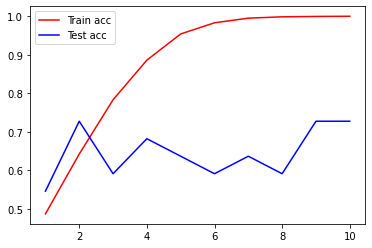

In [14]:
import matplotlib.pyplot as plt
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']

epoch = range(1,len(acc)+1)

plt.plot(epoch, acc, c = 'red',label = 'Train acc')
plt.plot(epoch, val_acc, c ='blue', label = 'Test acc')
plt.legend()
plt.plot()

증식을 이용해서 적은 데이터 개수를 늘려서 과대적합을 피해보자
- imageDataGenerator()함수를 통해서 수행
- 증식은 훈련데이터에서만 진행
- data augmentation : 이미지를 회전, 이동, 확대, 축소, 뒤집기 등을 통해서 데이터를 늘리는 작업

In [15]:
# test데이터를 증식하면 어려운데이터가 늘어나서 학습데이터에 크게 영향이없음

In [16]:
# 증식 설정
train_dataGen = ImageDataGenerator(rescale = 1./255,
                                  rotation_range=20,#회전을 할 범위
                                  width_shift_range = 0.1, #이동
                                  height_shift_range = 0.1,#이동
                                  shear_range = 0.1,#축소
                                  zoom_range = 0.1,#확대
                                  horizontal_flip = True,
                                  fill_mode='nearest'
                                  )

test_dataGen = ImageDataGenerator(rescale = 1./255)

In [17]:
train_generator = train_dataGen.flow_from_directory(train_dir,
                                               target_size = (150,150),
                                               batch_size = 50,
                                               class_mode = 'binary'
                                               # 이진분류 : binary
                                               # 다중분류 : categorical
                                               # 라벨 번호는 0부터 시작
                                               # 폴더는 알파벳 순으로 읽음
                                            )
test_generator = test_dataGen.flow_from_directory(test_dir,
                                               target_size = (150,150),
                                               batch_size = 50,
                                               class_mode = 'binary'
                                               # 이진분류 : binary
                                               # 다중분류 : categorical
                                               # 라벨 번호는 0부터 시작
                                               # 폴더는 알파벳 순으로 읽음
                                            )

Found 2000 images belonging to 2 classes.
Found 22 images belonging to 2 classes.


In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

from tensorflow.keras.layers import Conv2D,MaxPooling2D, Flatten
# Conv2D : 특징 찾기 (특징은 학습을 위한 데이터는 아님)
# MaxPooling2D : 불필요한 부분 삭제
# Flatten: 데이터 펴줌(2차원 데이터 > 1차원 데이터)

model2 = Sequential()

# 입력층 (CNN)
model2.add(Conv2D(filters= 32, # 사진에서 찾을 특성 개수  (내가 찾을려는 특징의 수)
                 kernel_size=(3,3), # 한번에 확인할 픽셀의 수 (특징의 크기)
                 input_shape = (150,150,3), #targetSize를 조정한만큼 넣어주면됨
                 #입력 데이터의 크기
                  # 1 - GrayScale
                  # 3 - 색상
                 padding = 'same', 
                  # 가장자리의 데이터가 부족 이를 0 으로 채움(정보누실막기)
                  #same = 입력데이터의 크기와 출력의 크기를 동일하게 
                  #valid 패팅을 사용하지 않겠다(가장자리의 데이터 손실감안)
                 activation = 'relu'))
                 #stride 자료를 얼마나 건너띌지(중요한 것만 탐색)

model2.add(MaxPooling2D(pool_size = (2,2)))
# pool_size -데이터 축소 ex) 2,2 를 하나의 데이터로 생각하겠다.
model2.add(Flatten()) #max_pooling2d의 데이터를 1차원 데이터로 펴줌
# 차원 축소 

# 은닉층
model2.add(Dense(units = 512,activation = 'relu'))
model2.add(Dense(units = 216,activation = 'relu'))
model2.add(Dense(units = 108,activation = 'relu'))
model2.add(Dense(units = 54,activation = 'relu'))

# 출력층
model2.add(Dense(units = 1, activation = 'sigmoid'))

model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 180000)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               92160512  
_________________________________________________________________
dense_3 (Dense)              (None, 216)               110808    
_________________________________________________________________
dense_4 (Dense)              (None, 108)               23436     
_________________________________________________________________
dense_5 (Dense)              (None, 54)               

In [19]:
model2.compile(loss = 'binary_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

In [20]:
history2 = model2.fit_generator(generator = train_generator,
                                # batch_size = 50으로 지정해뒀음
                                # 전체 데이터(2000)개를 다 읽어오려면 몇번
                                # 돌려야 하는지 입력
                               steps_per_epoch = 40,
                               epochs=10,
                               validation_data = test_generator,
                               validation_steps = 1)# 몇번 나눌것인지

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 40 steps, validate for 1 steps
Epoch 1/10
40/40 [==============================] - 11s 268ms/step - loss: 1.3892 - accuracy: 0.5105 - val_loss: 0.6789 - val_accuracy: 0.5909
Epoch 2/10
40/40 [==============================] - 10s 255ms/step - loss: 0.6783 - accuracy: 0.5465 - val_loss: 0.6530 - val_accuracy: 0.6364
Epoch 3/10
40/40 [==============================] - 10s 256ms/step - loss: 0.6565 - accuracy: 0.6030 - val_loss: 0.6556 - val_accuracy: 0.6818
Epoch 4/10
40/40 [==============================] - 10s 255ms/step - loss: 0.6272 - accuracy: 0.6415 - val_loss: 0.6426 - val_accuracy: 0.6818
Epoch 5/10
40/40 [==============================] - 10s 256ms/step - loss: 0.6183 - accuracy: 0.6700 - val_loss: 0.6139 - val_accuracy: 0.5455
Epoch 6/10
40/40 [==============================] - 10s 257ms/step - loss: 0.6037 - accuracy: 0.6725 - val_loss: 0.5745 - val_accuracy: 0.7727
Epoch 7/10
40/40 [==============================] -

[]

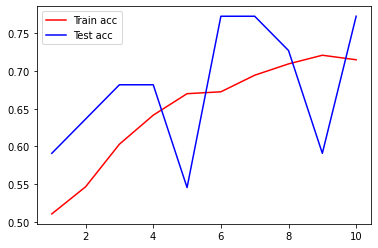

In [21]:
import matplotlib.pyplot as plt
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

epoch = range(1,len(acc)+1)

plt.plot(epoch, acc, c = 'red',label = 'Train acc')
plt.plot(epoch, val_acc, c ='blue', label = 'Test acc')
plt.legend()
plt.plot()

전이학습(transfer learning): 기존에 잘 만들어진 모델 가져다 쓰기
- 특성추출 : 기존의 모델을 특성 추출기로만 사용
- 미세조정 : 기존의 모델의 끝 층(dense층에 가까운 층) 까지 파라미터를 업데이트 하도록 하는것(기존에 우리가 만든 모델과 전이학습할 모델의 유사성을 높이는 것)


In [22]:
# VGG16 모델 전이학습
from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights = 'imagenet', # imagenet에 있는 가중치를 사용
                 include_top = False,#분류기를 사용할 것인지>
                  #False > 전이학습에서 특성추출 방식을 사용하겠다.
                 input_shape = (150,150,3)) #모델에 입력한 데이터 크기

In [23]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [24]:
# 전이학습 - 데이터가 충분히 확보되지 못한 경우에 학습효율 높여줌
#특성추출: 입력계층과 가까운 계층만 재사용 나머지는 신규학습
#미세조정방식 : 전이학습한 모델을 사용하는 대신 조금조금씩 적용

VGG16과 우리가 만든 분류기 결합하기

In [25]:
import os 
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# 데이터 폴더명 지정
train_dir = './dogs_vs_cats_small/train'
test_dir = './dogs_vs_cats_small/test'
validation_dir = './dogs_vs_cats_small/validation'

dataGen = ImageDataGenerator(rescale = 1./255)

batch_size = 20
# VGG16 특성추출기로 데이터를 보내서 특성을 추출하는 함수
# (데이터 폴더의 경로, 데이터의 개수)
def extract_features(directory, sample_count) :
    # VGG16에 데이터를 보내서 받은 특성과 라벨을 저장하기 위한 변수 설정
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    # 제너레이터에서 생성된 라벨값을 저장
    labels = np.zeros(shape=(sample_count))
    
    # VGG16으로 넘기기 위한 데이터를 제너레이터로 생성
    generator = dataGen.flow_from_directory(directory,
                                           target_size=(150, 150),
                                           batch_size=20,
                                           class_mode="binary")
    
    i = 0   # VGG16를 호출한 횟수
    # 제너레이터로부터 bath_size 개수만큼 데이터와 라벨을 가져온다
    for inputs_bacth, labels_batch in generator :
        # VGG16으로 데이터를 보내서 특성맵을 받아온다    
        features_batch = conv_base.predict(inputs_bacth)
        # features 리스트에 batch_size 개수만큼씩 VGG16에서 넘어온 특성을 추가
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        # labels에 batch_size 개수만큼씩 제너레이터에서 넘어온 라벨을 추가
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        
        i = i + 1 # 한 번에 하나씩 계속 진행해줌
        
        # 처리한 데이터 갯수가 전체 데이터 갯수(sample_count)보다 크면
        if i * batch_size >= sample_count :
            break
            
    return features, labels     

In [26]:
# 훈련, 테스트, 검증 데이터의 특성을 추출
# 2000, 22, 1000
train_feature, train_labels = extract_features(train_dir,2000) # 20000이라고 잘못입력되있었어요
test_feature, test_labels = extract_features(test_dir,22)
validation_feature, validation_labels = extract_features(validation_dir,1000)

Found 2000 images belonging to 2 classes.
Found 22 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [27]:
# 특성맵 데이터를 1차원으로 변환
train_features = np.reshape(train_feature,(2000, 4 * 4 *512))
test_features = np.reshape(test_feature,(22, 4 * 4 * 512))
validation_features = np.reshape(validation_feature,(1000,4 * 4 *512))

설계한 신경망층에 특성맵을 적용

In [28]:
# 이미 특성들을 추출되어 있기 때문에 MLP를 얇게 쌓아도 됨
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

model3 = Sequential()

model3.add(Dense(units = 256,
                input_dim = 4 * 4*512,
                activation = 'relu'))
model3.add(Dropout(0.5))

model3.add(Dense(units = 1,
                activation = 'sigmoid'))

model3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 257       
Total params: 2,097,665
Trainable params: 2,097,665
Non-trainable params: 0
_________________________________________________________________


In [29]:
from tensorflow.keras.optimizers import Adam
# 학습률 기본값 0.001
# 에러의 X 0.001 만큼 반영

In [30]:
model3.compile(loss = 'binary_crossentropy',
              optimizer = Adam(learning_rate = 0.01), # 러닝메이트를 적당하게 조정 너무 크면 발산
              metrics = ['accuracy'])

In [31]:
h3 = model3.fit(train_features, train_labels,
               batch_size = 20,
               epochs = 30,
               validation_data = (validation_features,validation_labels))

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 1s 290us/sample - loss: 1.6085 - accuracy: 0.7720 - val_loss: 0.3056 - val_accuracy: 0.8660
Epoch 2/30
2000/2000 [==============================] - 0s 136us/sample - loss: 0.3025 - accuracy: 0.8680 - val_loss: 0.2757 - val_accuracy: 0.8920
Epoch 3/30
2000/2000 [==============================] - 0s 135us/sample - loss: 0.3068 - accuracy: 0.8645 - val_loss: 0.2681 - val_accuracy: 0.8920
Epoch 4/30
2000/2000 [==============================] - 0s 135us/sample - loss: 0.2855 - accuracy: 0.8870 - val_loss: 0.3401 - val_accuracy: 0.8660
Epoch 5/30
2000/2000 [==============================] - 0s 136us/sample - loss: 0.2648 - accuracy: 0.8875 - val_loss: 0.2657 - val_accuracy: 0.8980
Epoch 6/30
2000/2000 [==============================] - 0s 134us/sample - loss: 0.2980 - accuracy: 0.8670 - val_loss: 0.3676 - val_accuracy: 0.8610
Epoch 7/30
2000/2000 [==============================] - 0s 136us

[]

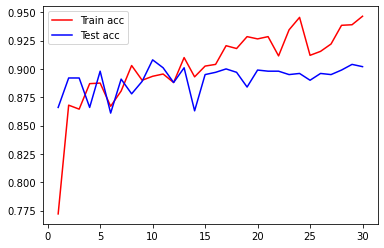

In [32]:
import matplotlib.pyplot as plt
acc = h3.history['accuracy']
val_acc = h3.history['val_accuracy']

epoch = range(1,len(acc)+1)

plt.plot(epoch, acc, c = 'red',label = 'Train acc')
plt.plot(epoch, val_acc, c ='blue', label = 'Test acc')
plt.legend()
plt.plot()

VGG모델 바로 적용시키기

In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten

model4 = Sequential()

# 우리가 설계할 모델에 VGG16끼워 넣기
model4.add(conv_base)# 입력층 끝

model4.add(Flatten())

model4.add(Dense(units = 256, activation = 'relu')) #은닉층
model4.add(Dense(units = 1, activation = 'sigmoid')) #출력층

model4.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


동결 : 기존의 모델을 우리가 설계할 모델에 그대로 삽입하면 오차역전파시에 기존 모델의 파라미터값도 갱신되어 많은 데이터로 학습한 기존 모델의 장점이 사라짐
- 기존 모델의 파라미터가 개신되지 않도록 해야함

In [34]:
# 동결되기 전의 훈련되는 VGG16의 가중치수 
print(len(model4.trainable_weights))

30


In [50]:
# VGG16의 전체 층에 대해 동결
#파라미터를 사용하지 않겠다.
conv_base.trainable = False

In [51]:
# 동결 후의 훈련되는 VGG16의 가중치수
print(len(model4.trainable_weights))

4


In [52]:
# 이미지 증식
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_dataGen = ImageDataGenerator(rescale = 1./255,
                                 rotation_range = 20,
                                 width_shift_range = 0.1,
                                 height_shift_range = 0.1,
                                 shear_range = 0.1,
                                 zoom_range = 0.1,
                                 horizontal_flip = True,
                                 fill_mode = 'nearest'
)

test_dataGen = ImageDataGenerator(rescale = 1./255)

train_generator = train_dataGen.flow_from_directory(train_dir,
                                                target_size = (150,150),
                                                batch_size = 10,
                                                class_mode = 'binary'
                                                # 이진분류 : binary
                                                # 다중분류 : categorical
                                                # 라벨 번호는 0부터 시작
                                                # 폴더는 알파벳 순으로 읽음
)

test_generator = test_dataGen.flow_from_directory(validation_dir,
                                                target_size = (150,150),
                                                batch_size = 10,
                                                class_mode = 'binary'
                                                # 이진분류 : binary
                                                # 다중분류 : categorical
                                                # 라벨 번호는 0부터 시작
                                                # 폴더는 알파벳 순으로 읽음
)


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [53]:
model4.compile(loss = 'binary_crossentropy',
              optimizer = Adam(learning_rate = 0.01), # 러닝메이트를 적당하게 조정 너무 크면 발산
               # 한번에 얼마만큼 많이 학습시킬 것인지 
              metrics = ['Accuracy'])

In [54]:
# 이미지 증식 후
# 증식한 이미지를 훈련
# 코드가 약간 다름 

In [55]:
h4 = model4.fit_generator(generator = train_generator,
               steps_per_epoch = 100,
               epochs = 20,
               validation_data = test_generator,
                          validation_steps=50)

  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 100 steps, validate for 50 steps
Epoch 1/20
100/100 [==============================] - 7s 69ms/step - loss: 0.6981 - Accuracy: 0.0000e+00 - val_loss: 0.6945 - val_Accuracy: 0.0000e+00
Epoch 2/20
100/100 [==============================] - 6s 62ms/step - loss: 0.6939 - Accuracy: 0.0000e+00 - val_loss: 0.6934 - val_Accuracy: 0.0000e+00
Epoch 3/20
100/100 [==============================] - 6s 63ms/step - loss: 0.6934 - Accuracy: 0.0000e+00 - val_loss: 0.6928 - val_Accuracy: 0.0000e+00
Epoch 4/20
100/100 [==============================] - 6s 62ms/step - loss: 0.6937 - Accuracy: 0.0000e+00 - val_loss: 0.6929 - val_Accuracy: 0.0000e+00
Epoch 5/20
100/100 [==============================] - 6s 62ms/step - loss: 0.6936 - Accuracy: 0.0000e+00 - val_loss: 0.6931 - val_Accuracy: 0.0000e+00
Epoch 6/20
100/100 [==============================] - 6s 62ms/step - loss: 0.6937 - Accuracy: 0.0000e+00 - val_loss: 0.6938 - val_Accuracy: 0.0000e+00
Epoch 7/20
100/100 [==============================]

[]

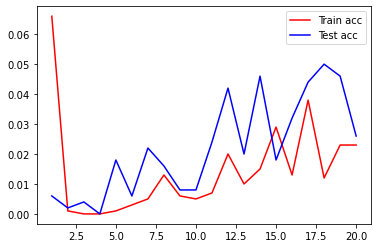

In [41]:
import matplotlib.pyplot as plt
acc = h4.history['Accuracy']
val_acc = h4.history['val_Accuracy']

epoch = range(1,len(acc)+1)

plt.plot(epoch, acc, c = 'red',label = 'Train acc')
plt.plot(epoch, val_acc, c ='blue', label = 'Test acc')
plt.legend()
plt.plot()


미세조정
- 기존의 모델과 우리 모델이 잘 연결되도록 기존 모델의 아랫층까지 학습이 가능하도록 만들어주는것

In [56]:
# Sequential 
# Dense, Dropout, Flatten 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten

model5 = Sequential()

# VGG16 끼워넣기
model5.add(conv_base)

model5.add(Flatten())

model5.add(Dense(256, activation = 'relu'))

model5.add(Dense(1,activation = 'sigmoid'))

model5.summary()



Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_4 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 256)               2097408   
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 257       
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________


In [57]:
# block2_conv1 층 까지만 학습이 되도록 미세조정


# VGG16 모델 전체가 학습이 되도록 설정
conv_base.trainable = True

set_trainable = False

# VGG16의 신경망층 한 층을 가져온다
for layer in conv_base.layers:
    #가져온 층의 이름이 block5_conv1이라면
    if layer.name == 'block5_conv1':
        set_trainable = True #학습하도록하고
    
    if set_trainable == True:
        layer.trainable = True
    else: 
        layer.trainable = False#학습하지 않도록하고

In [58]:
model5.compile(loss = 'binary_crossentropy',
              optimizer = 'adam',
              metrics = ['Accuracy'])

In [59]:
h5 = model5.fit_generator(generator = train_generator,
               steps_per_epoch = 100,
               epochs = 20,
               validation_data = test_generator,
                          validation_steps=50)

  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 100 steps, validate for 50 steps
Epoch 1/20
100/100 [==============================] - 7s 68ms/step - loss: 0.6932 - Accuracy: 0.0000e+00 - val_loss: 0.6931 - val_Accuracy: 0.0000e+00
Epoch 2/20
100/100 [==============================] - 6s 62ms/step - loss: 0.6932 - Accuracy: 0.0000e+00 - val_loss: 0.6931 - val_Accuracy: 0.0000e+00
Epoch 3/20
100/100 [==============================] - 6s 62ms/step - loss: 0.6933 - Accuracy: 0.0000e+00 - val_loss: 0.6931 - val_Accuracy: 0.0000e+00
Epoch 4/20
100/100 [==============================] - 6s 62ms/step - loss: 0.6932 - Accuracy: 0.0000e+00 - val_loss: 0.6931 - val_Accuracy: 0.0000e+00
Epoch 5/20
100/100 [==============================] - 6s 63ms/step - loss: 0.6932 - Accuracy: 0.0000e+00 - val_loss: 0.6933 - val_Accuracy: 0.0000e+00
Epoch 6/20
100/100 [==============================] - 6s 62ms/step - loss: 0.6932 - Accuracy: 0.0000e+00 - val_loss: 0.6932 - val_Accuracy: 0.0000e+00
Epoch 7/20
100/100 [==============================]

[]

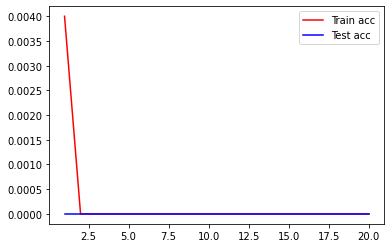

In [49]:
import matplotlib.pyplot as plt
acc = h5.history['Accuracy']
val_acc = h5.history['val_Accuracy']

epoch = range(1,len(acc)+1)

plt.plot(epoch, acc, c = 'red',label = 'Train acc')
plt.plot(epoch, val_acc, c ='blue', label = 'Test acc')
plt.legend()
plt.plot()
